<a href="https://colab.research.google.com/github/andrewright17/Homework-1-Deep-Learning/blob/problem-1.2-actual-task/MNIST_train_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1-1 Part 2

## Train on Actual Tasks

In this notebook we will be training a CNN on the MNIST data set.

### Import Libraries

In [1]:
### Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

### Specify GPU

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

Device cuda


### Model Hyperparameters

In [3]:
# Hyperparameters
#input_size = 784  # 28x28 flattened images
num_classes = 10
num_epochs = 50
batch_size = 64
learning_rate = 0.001

### Load MNIST Dataset

In [4]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 344169795.07it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 5803741.56it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 194567207.67it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3273286.73it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### View Image

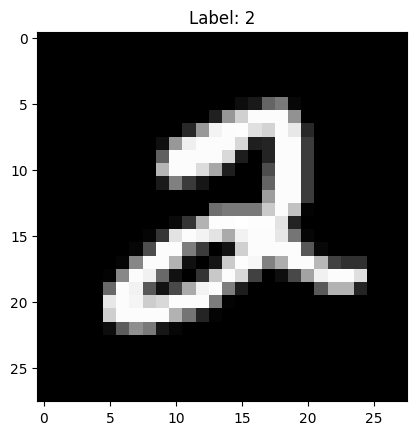

In [5]:
# Choose an image index
image_index = 5  # You can change this to any valid index

# Get the image and label
image, label = train_dataset[image_index]

# Convert the image tensor to a numpy array
image_array = image.numpy()

# Reshape the array to 28x28
image_array = image_array.reshape(28, 28)

# Display the image
plt.imshow(image_array, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

### Define CNN Classes

In [6]:
# CNN model
class CNN(nn.Module):
    def __init__(self, num_classes, out_channels_1, out_channels_2):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=out_channels_1, kernel_size=3, padding=1),
                                   nn.MaxPool2d(kernel_size=2),
                                   nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=out_channels_1, out_channels=out_channels_2,
                                             kernel_size=3, padding=1),
                                   nn.MaxPool2d(kernel_size=2),
                                   nn.ReLU())
        self.fc = nn.Linear(out_channels_2 * 7 * 7, num_classes)  # Assuming input images are 28x28


    def forward(self, x):
       x = self.conv1(x)
       x = self.conv2(x)
       x = x.view(x.size(0), -1)
       x = self.fc(x)
       return x

### Assign Model, Loss, and Optimizer

In [10]:
CNN_1 = CNN(num_classes=num_classes, out_channels_1=16, out_channels_2=32).to(device)
CNN_2 = CNN(num_classes=num_classes, out_channels_1=8, out_channels_2=16).to(device)

### Train Model and Evaluate Accuracy

In [8]:
### training function
def train_eval(model, num_epochs, learning_rate, train_loader, test_loader):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Training loop
    total_loss = []
    total_accuracy = []
    for epoch in range(num_epochs):
        train_loss = 0.0

        #Training
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Zero out Gradient and get checkpoints (memory efficiency)
            checkpoint_inputs = torch.utils.checkpoint.checkpoint(model, images)
            optimizer.zero_grad()


            # Forward pass
            outputs = model(checkpoint_inputs)
            loss = criterion(outputs, labels)
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            train_loss += loss * images.size(0)

        train_loss = train_loss/len(train_loader.sampler)
        total_loss.append(train_loss)
        print(f"train loss: {train_loss}")

        #Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        total_accuracy.append(accuracy)
        print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
    return total_loss, total_accuracy



In [9]:
### Train models
CNN_1_loss, CNN_1_accuracy = train_eval(model = CNN_1, num_epochs=num_epochs, learning_rate=learning_rate,
                                        train_loader=train_loader, test_loader=test_loader)
CNN_2_loss, CNN_2_accuracy = train_eval(model = CNN_2, num_epochs=num_epochs, learning_rate=learning_rate,
                                        train_loader=train_loader, test_loader=test_loader)

train loss: 0.2557739317417145
Accuracy of the network on the 10000 test images: 97.68 %
train loss: 0.07508731633424759
Accuracy of the network on the 10000 test images: 98.41 %
train loss: 0.05661168694496155
Accuracy of the network on the 10000 test images: 98.63 %
train loss: 0.04549906775355339
Accuracy of the network on the 10000 test images: 98.64 %
train loss: 0.038777995854616165
Accuracy of the network on the 10000 test images: 98.78 %
train loss: 0.032905738800764084
Accuracy of the network on the 10000 test images: 98.9 %
train loss: 0.02900022454559803
Accuracy of the network on the 10000 test images: 98.85 %
train loss: 0.025629807263612747
Accuracy of the network on the 10000 test images: 98.76 %
train loss: 0.02310141921043396
Accuracy of the network on the 10000 test images: 98.92 %
train loss: 0.020462727174162865
Accuracy of the network on the 10000 test images: 98.91 %
train loss: 0.017733419314026833
Accuracy of the network on the 10000 test images: 98.77 %
train l

KeyboardInterrupt: 

### Plot Results

In [ ]:
# Loss Plot
CNN_1_loss = torch.tensor(CNN_1_loss).cpu().data.numpy()
CNN_2_loss = torch.tensor(CNN_2_loss).cpu().data.numpy()
plt.plot(np.arange(0, len(CNN_1_loss), 1), CNN_1_loss, label = "CNN_1 Loss", color = "blue")
plt.plot(np.arange(0, len(CNN_1_loss), 1), CNN_2_loss, label = "CNN_2 Loss", color = "orange")
plt.legend()
plt.show()

# Accuracy Plot
plt.plot(np.arange(0, len(CNN_1_accuracy), 1), np.array(CNN_1_accuracy), label = "CNN_1 Accuracy", color = "blue")
plt.plot(np.arange(0, len(CNN_1_accuracy), 1), np.array(CNN_2_accuracy), label = "CNN_2 Accuracy", color = "orange")
plt.legend()
plt.show()